#  Image reconstruction in X-ray tomography

**Students:** Auguste de Lambilly, Lucas Versini

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time

## 1 - X-ray tomography

**1.**

In [4]:
x = scipy.io.loadmat('data/x.mat')['x'].squeeze()
H = scipy.io.loadmat('data/H.mat')['H']

print(f"Type of H: {type(H)}")
print(f"Shape of H: {H.shape}")

print(f"Shape of x: {x.shape}")

M, N = H.shape

assert M == 90 * 180
assert N == 90 * 90

Type of H: <class 'scipy.sparse._csc.csc_matrix'>
Shape of H: (16200, 8100)
Shape of x: (8100,)


**2.**

In [5]:
sigma = 1

noise = sigma * np.random.randn(M)

y = H @ x + noise

**3.**

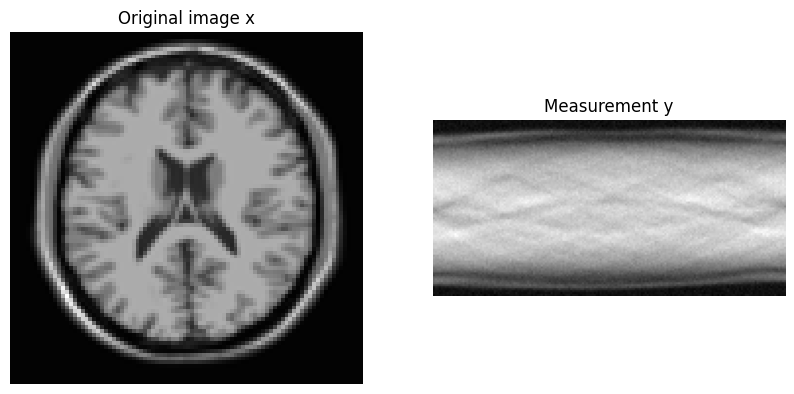

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].imshow(x.reshape((90, 90), order = "F"), cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Original image x')

ax[1].imshow(y.reshape((90, 180), order = "F"), cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Measurement y')

plt.show()

## 2 - Optimization problem

In [7]:
lambd = 0.13
delta = 0.02

**1.**

In [8]:
G = scipy.io.loadmat('data/G.mat')['G']

print(f"Type of G: {type(G)}")
print(f"Shape of G: {G.shape}")

Type of G: <class 'scipy.sparse._csc.csc_matrix'>
Shape of G: (16200, 8100)


**2.**


$$
\forall x \in \mathbb{R}^N, f(x) = \frac12 \| Hx - y \|^2 + \lambda r(x),
$$


so

$$
\forall x \in \mathbb{R}^N, \nabla f(x) = H^T (Hx - y) + \lambda \nabla r(x).
$$

And

$$
\forall x \in \mathbb{R}^N, r(x) = \sum_{n = 1}^{2N} \psi([Gx]^{(n)})
$$

so for $x \in \mathbb{R}^N, k \in \{ 1, \dots, N \}$, we have

$$

\begin{align*}
    \frac{\partial r}{\partial x_k}(x)
    & = \sum_{n = 1}^{2N} \psi'([Gx]^{(n)}) \frac{\partial [Gx]^{(n)}}{\partial x_k} \\
    & = \sum_{n = 1}^{2N} \psi'([Gx]^{(n)}) \frac{\partial}{\partial x_k} \left( \sum_{i = 1}^N [G]^{(n, i)} x_i \right) \\
    & = \sum_{n = 1}^{2N} \psi'([Gx]^{(n)}) [G]^{(n, k)} \\
    & = \sum_{n = 1}^{2N} [G^T]^{(k, n)} \psi'([Gx]^{(n)}) \\
    & = \left[ G^T \psi'(Gx) \right]^{(k)},
\end{align*}

$$

with $\psi'$ applied component-wise.

So $\forall x \in \mathbb{R}^N, \nabla r(x) = G^T \psi'(Gx)$, with $\psi'(u) = \dfrac{u}{\delta \sqrt{\delta^2 + u^2}}$.

Therefore:

$$
\forall x \in \mathbb{R}^N, \boxed{ \nabla f(x) = H^T (Hx - y) + \lambda G^T \left( \frac{[Gx]_i}{\delta \sqrt{\delta^2 + [Gx]_i^2}} \right)_{i = 1}^{2N} }.
$$


In [9]:
def psi(x, delta = delta): 
    return np.sqrt(1 + x**2 / delta**2)

def r(x, delta = delta):
    return psi(G.dot(x), delta).sum()

def f(x, lambd = lambd, delta = delta):
    q = H.dot(x) - y
    return 0.5 * q.T.dot(q) + lambd * r(x, delta)

def grad_f(x, lambd = lambd, delta = delta):
    G_x = G @ x
    grad_psi = G_x / (delta * np.sqrt(G_x**2 + delta**2))
    grad_r = G.T @ grad_psi

    return H.T @ (H @ x - y) + lambd * grad_r

**3.**

We first show that $\psi'$ is Lipschitz.

$$
\begin{align*}
\forall u \in \mathbb{R}, \psi''(u)
&= \dfrac{\sqrt{\delta^2 + u^2} - u \frac{2u}{2\sqrt{\delta^2 + u^2}}}{\delta(\delta^2 + u^2)} \\
&= \dfrac{\delta^2 + u^2 - u^2}{\delta(\delta^2 + u^2)^{3/2}} \\
&= \dfrac{\delta}{(\delta^2 + u^2)^{3/2}}\\
&\leq \dfrac{\delta}{(\delta^2)^{3/2}}\\
&= \dfrac{1}{\delta^2}.
\end{align*}
$$
So $\psi'$ is $\dfrac{1}{\delta^2}$-Lipschitz. Then, for $x, x' \in \mathbb{R}^N,$
$$
\begin{align*}
    \| \nabla f(x) - \nabla f(x') \|
    & = \| H^T H (x - x') + \lambda G^T (\psi'(Gx) - \psi'(Gx')) \| \\
    & \leq \| H^T H (x - x') \| + \lambda \| G^T (\psi'(Gx) - \psi'(Gx')) \| \\
    & \leq \| H^T H \|_2 \|x - x' \| + \lambda \| G \|_2 \| \psi'(Gx) - \psi'(Gx') \| \\
    & \leq \| H \|_2^2 \|x - x' \| + \lambda \| G \|_2 \sqrt{ \sum_{i = 1}^{2N} (\psi'([Gx]^{(i)}) - \psi'([Gx']^{(i)}))^2} \\
    & \leq \| H \|_2^2 \|x - x' \| + \frac{\lambda}{\delta^2} \| G \|_2 \sqrt{ \sum_{i = 1}^{2N} ([Gx]^{(i)} - [Gx']^{(i)})^2} \text{ ($\psi'$ is $1/\delta^2$-Lipschitz)} \\
    & = \| H \|_2^2 \|x - x' \| + \frac{\lambda}{\delta^2} \| G \|_2 \| G (x - x') \| \\
    & \leq \| H \|_2^2 \|x - x' \| + \frac{\lambda}{\delta^2} \| G \|_2^2 \| x - x' \| \\
    & = \left( \| H \|_2^2 + \frac{\lambda}{\delta^2} \| G \|_2^2 \right) \| x - x' \|.
\end{align*}
$$

So a Lipschitz constant of $\nabla f$ is $\boxed{ \| H \|_2^2 + \frac{\lambda}{\delta^2} \| G \|_2^2 }$.

In [10]:
norm_H = scipy.sparse.linalg.svds(H, k = 1, return_singular_vectors = False)
norm_G = scipy.sparse.linalg.svds(G, k = 1, return_singular_vectors = False)

L = norm_H**2 + lambd / delta**2 * norm_G**2

print(f"Lipschitz constant of grad_f: {L}")

Lipschitz constant of grad_f: [18092.77327686]


## 3 - Optimization algorithms

### 3.1 - Gradient descent algorithm

**1.**

In [11]:
x_0 = np.zeros(N)

**2.** We use a step size $\nu = 1.9 / L$ with $L$ the Lipschitz constant of $\nabla f$ (we have theoretical convergence for $\nu \in \left] 0, \dfrac{2}{L} \right[$).

In [12]:
def gradient_descent(x_0):
    x_n = x_0
    grad_f_x_n = grad_f(x_n)
    norm_grad_2 = grad_f_x_n @ grad_f_x_n

    nu = 1.9 / L
    
    n_iter = 0
    t0 = time.time()

    history_f = [f(x_n)]
    history_time = [time.time() - t0]

    while norm_grad_2 > N * 1e-8:
        n_iter += 1

        x_n = x_n - nu * grad_f_x_n

        grad_f_x_n = grad_f(x_n)
        norm_grad_2 = grad_f_x_n @ grad_f_x_n

        history_f.append(f(x_n))
        history_time.append(time.time() - t0)

        if n_iter % 500 == 0:
            print(f"Iteration {n_iter}, norm_grad_squared = {norm_grad_2:.3e}")
    return x_n, history_f, history_time

xGD, history_f_GD, history_time_GD = gradient_descent(x_0)

Iteration 500, norm_grad_squared = 4.359e+01
Iteration 1000, norm_grad_squared = 5.771e-01
Iteration 1500, norm_grad_squared = 3.608e-02
Iteration 2000, norm_grad_squared = 3.910e-03
Iteration 2500, norm_grad_squared = 5.050e-04


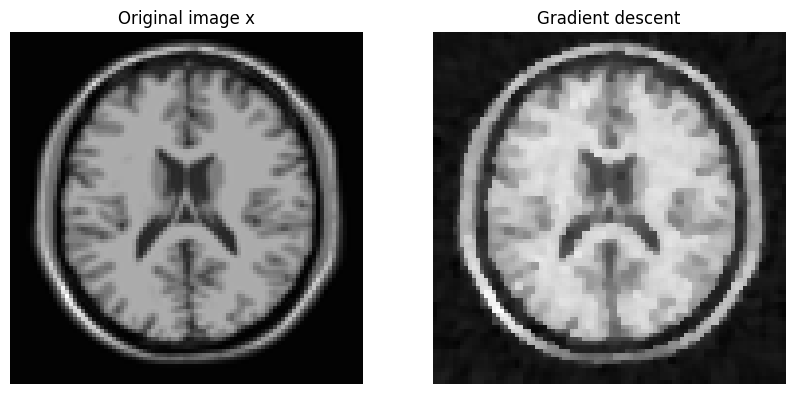

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].imshow(x.reshape((90, 90), order = "F"), cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Original image x')

ax[1].imshow(xGD.reshape((90, 90), order = "F"), cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Gradient descent')

plt.show()

The result is rather good (even though brighter than the real image).

### 3.2 - MM quadratic algorithm

**1.**

Since $\psi$ is an even function, we have $\forall x \in \mathbb{R}, \psi(|x|) = \psi(x)$.

- $\psi$ is differentiable on $]0, +\infty[$. Its derivative is given by $\psi'(x) = \dfrac{x}{\delta \sqrt{\delta^2 + x^2}}$.

- $\forall x > 0, \frac{d}{dx} \psi(\sqrt{x}) = \frac{1}{2\sqrt{x}} \psi'(\sqrt{x}) = \dfrac{1}{2\sqrt{x}} \dfrac{\sqrt{x}}{\delta \sqrt{\delta^2 + x}} = \dfrac{1}{2\delta \sqrt{\delta^2 + x}}$ which is strictly decreasing, so $\psi(\sqrt{\cdot})$ is a (strictly) concave function.

- $\forall x \geq 0, \psi'(x) = \dfrac{x}{\delta \sqrt{\delta^2 + x^2}} \geq 0$.

- $\omega(x) := \dfrac{\psi'(x)}{x} = \dfrac{1}{\delta \sqrt{\delta^2 + x^2}} \underset{x\to 0, x > 0}{\longrightarrow} \dfrac{1}{\delta^2} \in \mathbb{R}$.

So we know (slide 13/40 in the `cours_ECP_MM.pdf` slides) that for each $x' \in \mathbb{R}$, we have (since $\omega$ is also an even function)
$$
\forall x \in \mathbb{R}, \psi(x) \leq \psi(x') + \psi'(x') (x - x') + \frac12 \omega(x') (x - x')^2.
$$

In particular, for any vectors $x, x' \in \mathbb{R}^N$, we have for each $n \in [\![ 1, 2N ]\!]$:
$$
\psi([Gx]^{(n)}) \leq \psi([Gx']^{(n)}) + \psi'([Gx']^{(n)}) ([Gx]^{(n)} - [Gx']^{(n)}) + \frac12 \omega([Gx']^{(n)}) ([Gx]^{(n)} - [Gx']^{(n)})^2.
$$
We sum this over $n$ to get:
$$
r(x) \leq r(x') + \langle \psi'(Gx') \mid Gx - Gx' \rangle + \frac12 (Gx - Gx')^\top \text{Diag}(\omega(Gx')) (Gx - Gx'),
$$
where both $\psi'$ and $\omega$ are applied component-wise to vectors, and $\text{Diag}$ turns a vector into a diagonal matrix. This can be rewritten:
$$
r(x) \leq r(x') + \langle G^\top \psi'(Gx') \mid x - x' \rangle + \frac12 (x - x')^\top G^\top \text{Diag}(\omega(Gx')) G (x - x').
$$
And we have $\nabla r(z) = G^\top \psi'(Gz)$, so finally:
$$
r(x) \leq r(x') + \langle \nabla r(x') \mid x - x' \rangle + \frac12 (x - x')^\top G^\top \text{Diag}(\omega(Gx')) G (x - x').
$$

Moreover, using Taylor's formula, we have
$$
\frac12 \| Hx - y \|^2 = \frac12 \| Hx' - y \|^2 + \langle H^\top(Hx' - y) \mid x - x' \rangle + \frac12 (x' - x)^\top H^\top H (x - x').
$$

So overall, since $f(x) = \frac12 \| Hx - y \|^2 + \lambda r(x)$ with $\lambda > 0$:
$$
\boxed{f(x) \leq f(x') + \langle \nabla f(x) \mid x - x' \rangle + \frac12 \| x - x' \|_{A(x')}^2}
$$
where $\boxed{A(x') = H^\top H + \lambda G^\top \text{Diag}(\omega(Gx')) G}$, with $\left[ \text{Diag}(\omega(Gx')) \right]^{(n)} = \dfrac{1}{\delta \sqrt{\delta^2 + ([Gx']^{(n)})^2}}$.

And there is of course equality when $x = x'$.

In [14]:
def D(x, delta = delta):
    """ Compute Diag(omega(Gx)) """
    d = 1. / (delta * np.sqrt(delta**2 + (G @ x)**2))
    return scipy.sparse.diags(d).tocsc()

def curvature_majorant(x, lambd = lambd, delta = delta):
    """ Compute the majorant curvature operator """
    curvature_operator = lambda z: H.T @ (H @ z) + lambd * G.T @ (D(x, delta) @ (G @ z))
    return scipy.sparse.linalg.LinearOperator((N, N), matvec = curvature_operator, rmatvec = curvature_operator)

**2.** In the algorithm seen in the lectures, we need a sequence $(\theta_n)$ valued in $(0, 2)$. Here, we take $\forall n, \theta_n = 1$.

In [15]:
def MM_quadratic(grad_f, curvature_majorant, x_0, theta):
    x_n = x_0
    grad_f_x_n = grad_f(x_n)
    norm_grad_2 = grad_f_x_n @ grad_f_x_n

    n_iter = 0
    t0 = time.time()

    history_f = [f(x_n)]
    history_time = [time.time() - t0]
    
    while norm_grad_2 > N * 1e-8:
        n_iter += 1
        
        x_n = x_n - theta * scipy.sparse.linalg.bicg(curvature_majorant(x_n), grad_f_x_n)[0]
        
        grad_f_x_n = grad_f(x_n)
        norm_grad_2 = grad_f_x_n @ grad_f_x_n

        history_f.append(f(x_n))
        history_time.append(time.time() - t0)
        
        if n_iter % 5 == 0:
            print(f"Iteration {n_iter}, norm_grad_squared = {norm_grad_2:.3e}")
    
    print(f"Converged in {n_iter} iterations")
    
    return x_n, history_f, history_time

In [16]:
x_quadratic, history_f_quadratic, history_time_quadratic = MM_quadratic(grad_f, curvature_majorant, x_0, 1)

Iteration 5, norm_grad_squared = 4.720e+03
Iteration 10, norm_grad_squared = 2.427e+02
Iteration 15, norm_grad_squared = 2.450e+01
Iteration 20, norm_grad_squared = 4.054e+00
Iteration 25, norm_grad_squared = 9.565e-01
Iteration 30, norm_grad_squared = 2.865e-01
Iteration 35, norm_grad_squared = 1.013e-01
Iteration 40, norm_grad_squared = 4.023e-02
Iteration 45, norm_grad_squared = 1.726e-02
Iteration 50, norm_grad_squared = 7.780e-03
Iteration 55, norm_grad_squared = 3.619e-03
Iteration 60, norm_grad_squared = 1.717e-03
Iteration 65, norm_grad_squared = 8.253e-04
Iteration 70, norm_grad_squared = 4.001e-04
Iteration 75, norm_grad_squared = 1.951e-04
Iteration 80, norm_grad_squared = 9.556e-05
Converged in 82 iterations


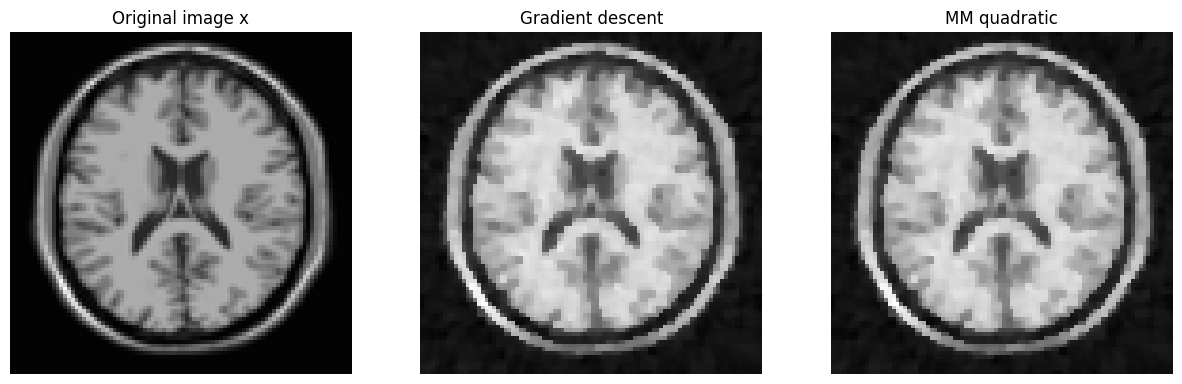

In [17]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

ax[0].imshow(x.reshape((90, 90), order = "F"), cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Original image x')

ax[1].imshow(xGD.reshape((90, 90), order = "F"), cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Gradient descent')

ax[2].imshow(x_quadratic.reshape((90, 90), order = "F"), cmap = 'gray')
ax[2].axis('off')
ax[2].set_title('MM quadratic')

plt.show()

Visually speaking, the results obtained with Gradient Descent and MM quadratic algorithm look very similar.

### 3.3 - 3MG algorithm

In [18]:
def curvature_majorant_3MG(x, mat_subspace, lambd = lambd, delta = delta):
    G_times_mat = G @ mat_subspace
    H_times_mat = H @ mat_subspace
    return H_times_mat.T @ H_times_mat + lambd * G_times_mat.T @ (D(x, delta) @ G_times_mat)

def threeMG_algorithm(grad_f, x_0, lambd = lambd, delta = delta, verbose = True):
    x_n = x_0
    x_previous = x_n

    grad_f_x_n = grad_f(x_n, lambd, delta)
    norm_grad_2 = grad_f_x_n @ grad_f_x_n
    
    n_iter = 0
    t0 = time.time()

    history_f = [f(x_n, lambd, delta)]
    history_time = [time.time() - t0]
    
    while norm_grad_2 > N * 1e-8:
        n_iter += 1

        d1 = -grad_f_x_n
        d2 = x_n - x_previous

        mat_subspace = np.concatenate((d1[:, None], d2[:, None]), axis = 1)
        x_previous = x_n
        
        x_n = x_previous - mat_subspace @ (scipy.linalg.pinv(curvature_majorant_3MG(x_previous, mat_subspace, lambd, delta)) @ (mat_subspace.T @ grad_f_x_n))
        
        grad_f_x_n = grad_f(x_n, lambd, delta)
        norm_grad_2 = grad_f_x_n @ grad_f_x_n

        history_f.append(f(x_n, lambd, delta))
        history_time.append(time.time() - t0)

        if n_iter % 50 == 0 and verbose:
            print(f"Iteration {n_iter}, norm_grad_squared = {norm_grad_2:.3e}")
    
    if verbose:
        print(f"Converged in {n_iter} iterations")
    
    return x_n, history_f, history_time

In [19]:
x_3MG, history_f_3MG, history_time_3MG = threeMG_algorithm(grad_f, x_0)

Iteration 50, norm_grad_squared = 1.120e+02
Iteration 100, norm_grad_squared = 7.113e-02
Iteration 150, norm_grad_squared = 1.012e-04
Converged in 151 iterations


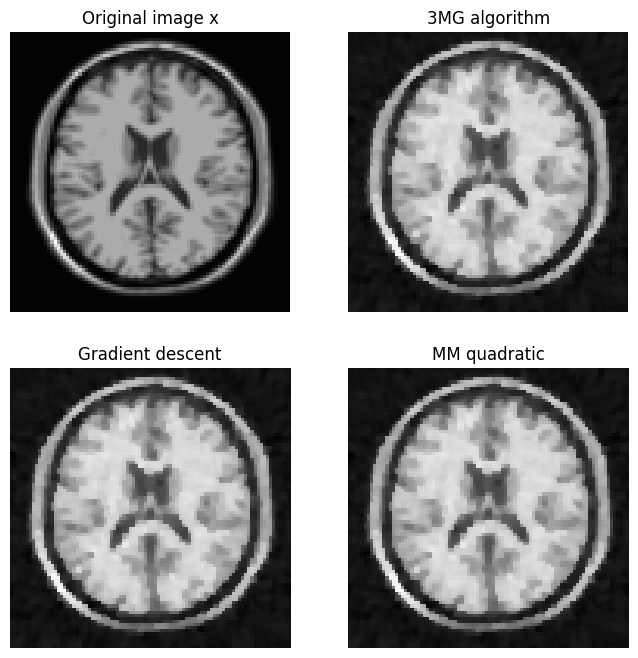

In [20]:
fig, ax = plt.subplots(2, 2, figsize = (8, 8))

ax[0,0].imshow(x.reshape((90, 90), order = "F"), cmap = 'gray')
ax[0,0].axis('off')
ax[0,0].set_title('Original image x')

ax[0,1].imshow(x_3MG.reshape((90, 90), order = "F"), cmap = 'gray')
ax[0,1].axis('off')
ax[0,1].set_title('3MG algorithm')

ax[1,0].imshow(xGD.reshape((90, 90), order = "F"), cmap = 'gray')
ax[1,0].axis('off')
ax[1,0].set_title('Gradient descent')

ax[1,1].imshow(x_quadratic.reshape((90, 90), order = "F"), cmap = 'gray')
ax[1,1].axis('off')
ax[1,1].set_title('MM quadratic')

plt.show()

### 3.4 - Block-coordinate MM quadratic algorithm

**1.**

In [21]:
H_csc = H.tocsc()
G_csc = G.tocsc()

def curvature_majorant_block(x, j, Nj):
    H_j = H_csc[:, (j - 1) * Nj: j * Nj]
    G_j = G_csc[:, (j - 1) * Nj: j * Nj]

    d = 1. / (delta * np.sqrt(delta**2 + (G @ x)**2))
    D = scipy.sparse.diags(d).tocsc()
    
    def curvature_operator(z):
        return H_j.T @ (H_j @ z) + lambd * G_j.T @ (D @ (G_j @ z))
    return scipy.sparse.linalg.LinearOperator((Nj, Nj), matvec = curvature_operator, rmatvec = curvature_operator)

In [22]:
def block_coordinate(grad_f, x_0, K = 9):
    x_n = x_0.copy()
    Nj = N // K

    grad_f_x_n = grad_f(x_n)
    norm_grad_2 = grad_f_x_n @ grad_f_x_n

    n_iter = 0
    t0 = time.time()

    history_f = [f(x_n)]
    history_time = [time.time() - t0]

    while n_iter < 1000 and norm_grad_2 > N * 1e-8:
        n_iter += 1
        j = (n_iter - 1) % K + 1

        grad_f_x_n = grad_f(x_n)
        matA = curvature_majorant_block(x_n, j, Nj)
        x_n[Nj * (j - 1): j * Nj] -= scipy.sparse.linalg.bicg(matA, grad_f_x_n[Nj * (j - 1): j * Nj])[0]

        norm_grad_2 = grad_f_x_n @ grad_f_x_n
        history_f.append(f(x))
        history_time.append(time.time() - t0)

        if n_iter % 50 == 0:
            print(f"Iteration {n_iter}, norm_grad_squared = {norm_grad_2:.3e}")
    return x_n, history_f, history_time

x_BC, history_f_BC, history_time_BC = block_coordinate(grad_f, x_0)

Iteration 50, norm_grad_squared = 1.501e+07
Iteration 100, norm_grad_squared = 2.433e+04
Iteration 150, norm_grad_squared = 3.370e+02
Iteration 200, norm_grad_squared = 1.297e+01
Iteration 250, norm_grad_squared = 1.594e+00
Iteration 300, norm_grad_squared = 3.110e-01
Iteration 350, norm_grad_squared = 8.761e-02
Iteration 400, norm_grad_squared = 2.997e-02
Iteration 450, norm_grad_squared = 1.193e-02
Iteration 500, norm_grad_squared = 4.797e-03
Iteration 550, norm_grad_squared = 2.176e-03
Iteration 600, norm_grad_squared = 9.150e-04
Iteration 650, norm_grad_squared = 4.356e-04
Iteration 700, norm_grad_squared = 1.849e-04
Iteration 750, norm_grad_squared = 7.888e-05


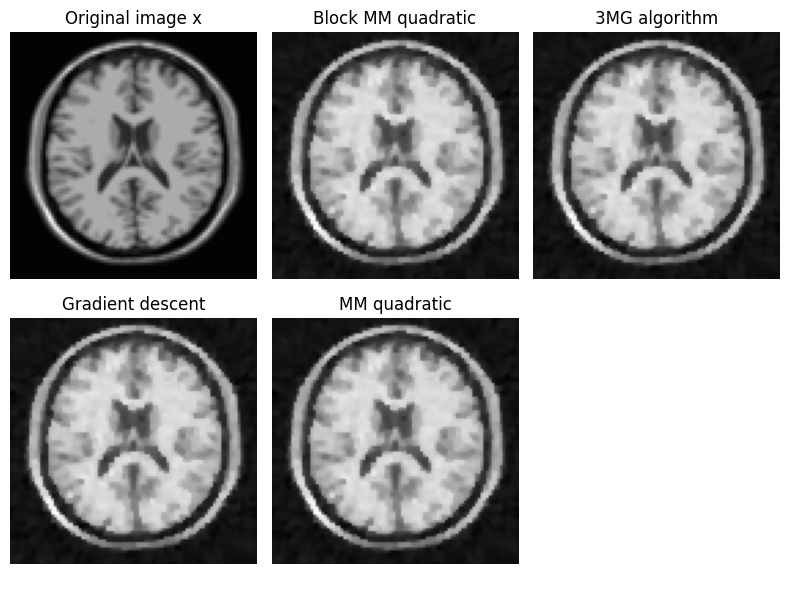

In [23]:
fig, ax = plt.subplots(2, 3, figsize = (8, 6))

ax[0,0].imshow(x.reshape((90, 90), order = "F"), cmap = 'gray')
ax[0,0].axis('off')
ax[0,0].set_title('Original image x')

ax[0,1].imshow(x_BC.reshape((90, 90), order = "F"), cmap = 'gray')
ax[0,1].axis('off')
ax[0,1].set_title('Block MM quadratic')

ax[0,2].imshow(x_3MG.reshape((90, 90), order = "F"), cmap = 'gray')
ax[0,2].axis('off')
ax[0,2].set_title('3MG algorithm')

ax[1,0].imshow(xGD.reshape((90, 90), order = "F"), cmap = 'gray')
ax[1,0].axis('off')
ax[1,0].set_title('Gradient descent')

ax[1,1].imshow(x_quadratic.reshape((90, 90), order = "F"), cmap = 'gray')
ax[1,1].axis('off')
ax[1,1].set_title('MM quadratic')

ax[1, 2].axis('off')

plt.tight_layout()
plt.show()

###  3.5 - Parallel MM quadratic algorithm

**1.**

Set $w_{n, i} = \dfrac{|H^{(n, i)}|}{\sum\limits_{k = 1}^N |H^{(n, k)}|}$ so that $w_{n, i} \geq 0$ and $\sum\limits_{i = 1}^N w_{n, i} = 1$.

$$
\begin{align*}
    x^\top H^\top H x
    & = \sum_{n = 1}^{2N} ([Hx]^{(n)})^2 \\
    & = \sum_{n = 1}^{2N} \left( \sum_{i = 1}^N H^{(n, i)} x_i \right)^2 \\
    & = \sum_{n = 1}^{2N} \left( \sum_{i = 1}^N w_{n, i} \dfrac{H^{(n, i)} x_i}{w_{n, i}} \right)^2 \\
    & \leq \sum_{n = 1}^{2N} \sum_{i = 1}^N w_{n, i} \left( \dfrac{H^{(n, i)} x_i}{w_{n, i}} \right)^2 \text{ (Jensen)} \\
    & = \sum_{n = 1}^{2N} \sum_{i = 1}^N \dfrac{(H^{(n, i)})^2 x_i^2}{w_{n, i}} \\
    & = \sum_{n = 1}^{2N} \sum_{i = 1}^N |H^{(n, i)}| x_i^2 \sum\limits_{k = 1}^N |H^{(n, k)}| \\
    & = \sum_{n = 1}^{2N} \sum_{i = 1}^N \mathcal{H}_{i}^{(n)} x_i^2  \\
    & = \sum_{i = 1}^N x_i^2 \mathcal{H}_{i}^\top {\bf 1}  \\
    & = x^\top \text{Diag}(\mathcal{H}_{i}^\top {\bf 1}) x.
\end{align*}
$$

When we apply the Jensen inequality, note that $w_{n,i} = 0 \iff H_{n,i} = 0$, so we can only consider the non null terms in the sum.

In the above, $\mathcal{H}_{i}^{(n)} = |H^{(n, i)}| \sum\limits_{k = 1}^N |H^{(n, k)}|$ is the $i$-th component of the $\mathcal{H}$ in the formula of $b^{(i)}.$

Set $v_{n,i} = \dfrac{|G^{(n, i)}|}{\sum\limits_{k = 1}^N |G^{(n, k)}|}$. Therefore, $v_{n, i} \geq 0$ and $\sum\limits_{i = 1}^N v_{n, i} = 1$.

$$
\begin{align*}
    x^\top G^\top \text{Diag}(\omega(Gx')) G x &= (Gx)^\top \text{Diag}(\omega(Gx)) (Gx) \\
    &= \sum_{n = 1}^{2N} \omega([G x']^{(n)})\cdot ([Gx]^{(n)})^2\\
    &= \sum_{n = 1}^{2N} \omega([G x']^{(n)}) \bigg(\sum_{i=1}^{N} G^{(n,i)} x_i\bigg)^2\\
    &= \sum_{n = 1}^{2N} \omega([G x']^{(n)}) \bigg(\sum_{i=1}^{N} v_{n,i}\dfrac{G^{(n,i)} x_i}{v_{n,i}}\bigg)^2\\
    &\leq \sum_{n = 1}^{2N} \omega([G x']^{(n)}) \sum_{i=1}^{N} v_{n,i} \bigg(\dfrac{G^{(n,i)} x_i}{v_{n,i}}\bigg)^2 \text{(Jensen)}\\
    &= \sum_{n = 1}^{2N} \omega([G x']^{(n)}) \sum_{i=1}^{N}  \dfrac{(G^{(n,i)})^2 x_i^2}{v_{n,i}}\\
    &= \sum_{n = 1}^{2N} \omega([G x']^{(n)}) \sum_{i=1}^{N}  x_i^2 |G^{(n,i)}| \sum\limits_{k = 1}^N |G^{(n, k)}|  \\
    &= \sum_{n = 1}^{2N} \omega([G x]^{(n)}) \sum_{i=1}^{N}  x_i^2 \mathcal{G}_{i}^{(n)}  \\
    &= \sum_{i=1}^{N}  x_i^2 \sum_{n = 1}^{2N} \omega([G x']^{(n)})  \mathcal{G}_{i}^{(n)} \\
    &= \sum_{i=1}^{N}  x_i^2 \mathcal{G}_{i}^\top \omega(Gx') \\
    &= x^\top \text{Diag}(\mathcal{G}_i^\top \omega(Gx')) x.
\end{align*}
$$

When we apply the Jensen inequality, note that $v_{n,i} = 0 \iff G_{n,i} = 0$, so we can only consider the non null terms in the sum.

In the above, $\mathcal{G}_{i}^{(n)}= |G^{(n, i)}| \sum\limits_{k = 1}^N |G^{(n, k)}|$ is the $i$-th component of the $\mathcal{G}$ in the formula of $b^{(i)}$.

Like in the previous questions, $\omega(x) = \dfrac{\psi'(x)}{x}$.


By summing the two inequalities, we get :

$$
\forall x \in \mathbb{R}^N, \forall x' \in \mathbb{R}^N, (x')^\top A(x) x' \leq (x')^\top B(x) x'.
$$

Therefore :

$$
\forall x \in \mathbb{R}^N,  A(x) \preceq B(x).
$$

**2.** 

In [24]:
H_t1 = (np.abs(H).T @ np.sum(np.abs(H), axis = 1)).A1
G_ = (np.abs(G).multiply(np.sum(np.abs(G), axis = 1))).tocsc()

def B(x):
    Gx = G.dot(x)
    G_diag = lambd * G_.T @ (1. / (delta * np.sqrt(delta**2 + (Gx)**2)))
    return H_t1 + G_diag

def parallel_MM_quadratic(grad_f, x_0, theta):
    x_n = x_0.copy()
    grad_f_x_n = grad_f(x_n)
    norm_grad_2 = grad_f_x_n @ grad_f_x_n

    n_iter = 0
    t0 = time.time()

    history_f = [f(x_n)]
    history_time = [time.time() - t0]
    
    while norm_grad_2 > N * 1e-8:
        n_iter += 1
        
        b_vals = B(x_n)  
        x_n -= theta * (grad_f_x_n / b_vals)  
        
        grad_f_x_n = grad_f(x_n)
        norm_grad_2 = grad_f_x_n @ grad_f_x_n

        history_f.append(f(x_n))
        history_time.append(time.time() - t0)

        if n_iter % 200 == 0:
            print(f"Iteration {n_iter}, norm_grad_squared = {norm_grad_2:.3e}")
    
    print(f"Converged in {n_iter} iterations")
    
    return x_n, history_f, history_time

In [25]:
x_pMMq, history_f_pMMq, history_time_pMMQ = parallel_MM_quadratic(grad_f, x_0, 1)

Iteration 200, norm_grad_squared = 1.814e+04
Iteration 400, norm_grad_squared = 1.528e+03
Iteration 600, norm_grad_squared = 2.673e+02
Iteration 800, norm_grad_squared = 5.944e+01
Iteration 1000, norm_grad_squared = 1.585e+01
Iteration 1200, norm_grad_squared = 5.008e+00
Iteration 1400, norm_grad_squared = 1.813e+00
Iteration 1600, norm_grad_squared = 7.312e-01
Iteration 1800, norm_grad_squared = 3.215e-01
Iteration 2000, norm_grad_squared = 1.516e-01
Iteration 2200, norm_grad_squared = 7.561e-02
Iteration 2400, norm_grad_squared = 3.947e-02
Iteration 2600, norm_grad_squared = 2.136e-02
Iteration 2800, norm_grad_squared = 1.189e-02
Iteration 3000, norm_grad_squared = 6.773e-03
Iteration 3200, norm_grad_squared = 3.925e-03
Iteration 3400, norm_grad_squared = 2.307e-03
Iteration 3600, norm_grad_squared = 1.370e-03
Iteration 3800, norm_grad_squared = 8.206e-04
Iteration 4000, norm_grad_squared = 4.947e-04
Iteration 4200, norm_grad_squared = 2.998e-04
Iteration 4400, norm_grad_squared = 1.

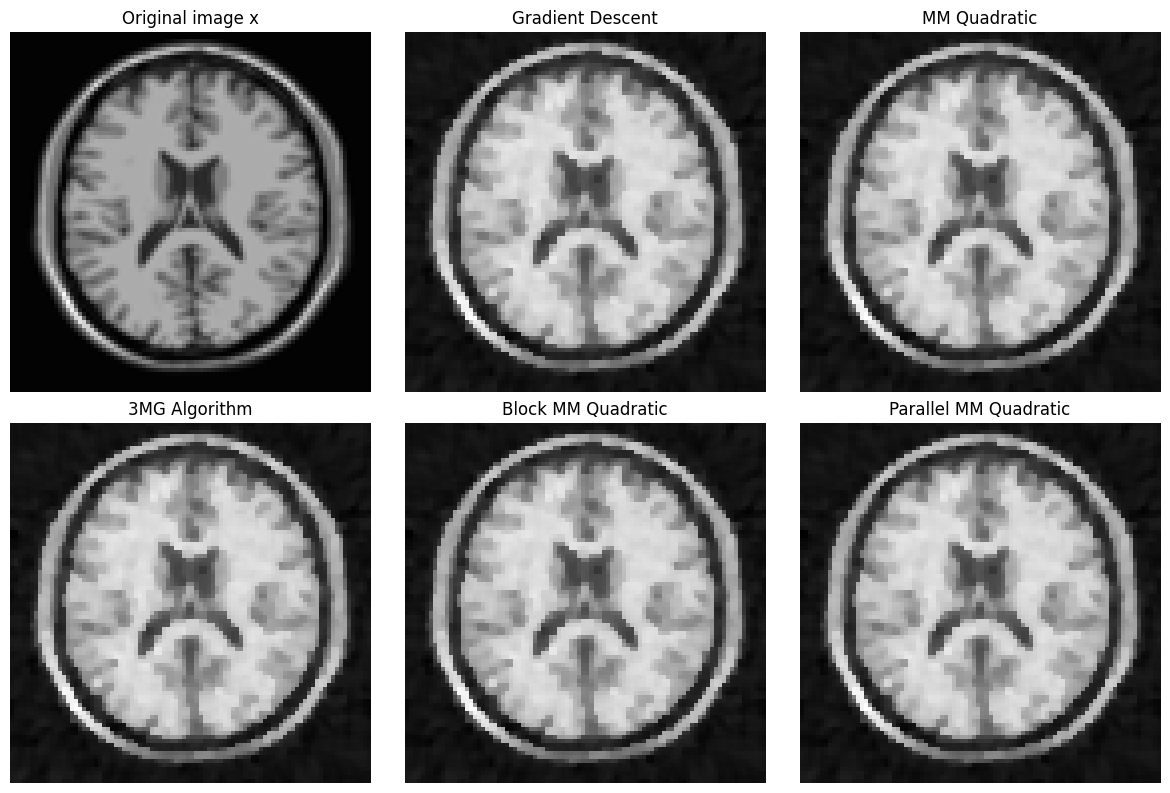

In [26]:
fig, ax = plt.subplots(2, 3, figsize = (12, 8))

# Original image
ax[0, 0].imshow(x.reshape((90, 90), order="F"), cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('Original image x')

# Gradient descent
ax[0, 1].imshow(xGD.reshape((90, 90), order="F"), cmap='gray')
ax[0, 1].axis('off')
ax[0, 1].set_title('Gradient Descent')

# MM quadratic
ax[0, 2].imshow(x_quadratic.reshape((90, 90), order="F"), cmap='gray')
ax[0, 2].axis('off')
ax[0, 2].set_title('MM Quadratic')

# 3MG algorithm
ax[1, 0].imshow(x_3MG.reshape((90, 90), order="F"), cmap='gray')
ax[1, 0].axis('off')
ax[1, 0].set_title('3MG Algorithm')

# Block-coordinate MM quadratic
ax[1, 1].imshow(x_BC.reshape((90, 90), order="F"), cmap='gray')
ax[1, 1].axis('off')
ax[1, 1].set_title('Block MM Quadratic')

# Parallel MM quadratic
ax[1, 2].imshow(x_pMMq.reshape((90, 90), order="F"), cmap='gray')
ax[1, 2].axis('off')
ax[1, 2].set_title('Parallel MM Quadratic')

plt.tight_layout()
plt.show()

###  3.6 - Comparison of the methods

**1. and 2.** The previous functions already contain the required changes.

In [27]:
print(f"Time taken for Gradient Descent: {history_time_GD[-1]:.3f} seconds")
print(f"Time taken for MM Quadratic: {history_time_quadratic[-1]:.3f} seconds")
print(f"Time taken for 3MG Algorithm: {history_time_3MG[-1]:.3f} seconds")
print(f"Time taken for Block MM Quadratic: {history_time_BC[-1]:.3f} seconds")
print(f"Time taken for Parallel MM Quadratic: {history_time_pMMQ[-1]:.3f} seconds")

Time taken for Gradient Descent: 36.273 seconds
Time taken for MM Quadratic: 44.608 seconds
Time taken for 3MG Algorithm: 3.361 seconds
Time taken for Block MM Quadratic: 48.181 seconds
Time taken for Parallel MM Quadratic: 60.399 seconds


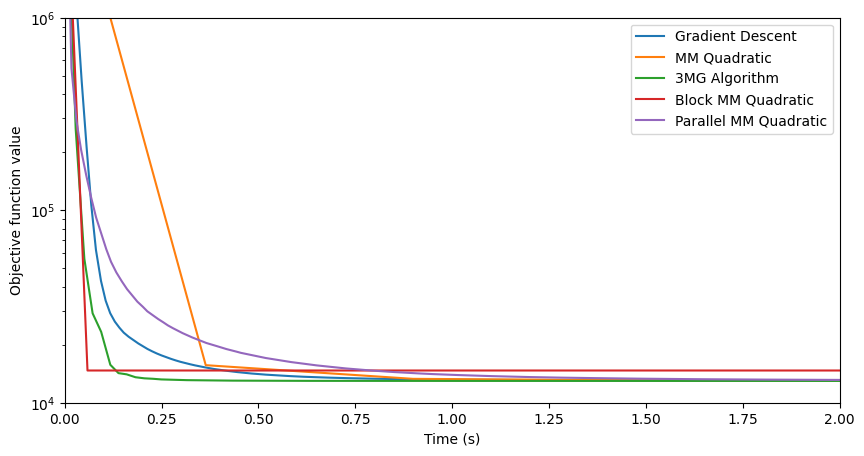

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

ax.plot(history_time_GD, history_f_GD, label = 'Gradient Descent')
ax.plot(history_time_quadratic, history_f_quadratic, label = 'MM Quadratic')
ax.plot(history_time_3MG, history_f_3MG, label = '3MG Algorithm')
ax.plot(history_time_BC, history_f_BC, label = 'Block MM Quadratic')
ax.plot(history_time_pMMQ, history_f_pMMq, label = 'Parallel MM Quadratic')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Objective function value')

ax.set_xlim([0, 2])
ax.set_yscale('log')
ax.set_ylim([1e4, 1e6])

ax.legend()
plt.show()

**3.** First of all, we can compute the SNR for all the algorithms.

In [29]:
def SNR(x, x_hat):
    return 10 * np.log10(np.linalg.norm(x)**2 / np.linalg.norm(x - x_hat)**2)

print(f"SNR for Gradient Descent: {SNR(x, xGD):.6f} dB")
print(f"SNR for MM Quadratic: {SNR(x, x_quadratic):.6f} dB")
print(f"SNR for 3MG Algorithm: {SNR(x, x_3MG):.6f} dB")
print(f"SNR for Block MM Quadratic: {SNR(x, x_BC):.6f} dB")
print(f"SNR for Parallel MM Quadratic: {SNR(x, x_pMMq):.6f} dB")

SNR for Gradient Descent: 18.831614 dB
SNR for MM Quadratic: 18.831605 dB
SNR for 3MG Algorithm: 18.831586 dB
SNR for Block MM Quadratic: 18.831606 dB
SNR for Parallel MM Quadratic: 18.831614 dB


We see they are very similar. Now, we use 3MG (fastest algorithm among the ones we tried) and we use a grid-search to find the best values for $(\lambda, \delta)$.

SNR for lambda = 1.1, delta = 0.1: 19.476836 dB, time = 2.323 seconds
SNR for lambda = 1.1, delta = 0.10500000000000001: 19.506746 dB, time = 2.348 seconds
SNR for lambda = 1.1, delta = 0.11: 19.517569 dB, time = 2.467 seconds
SNR for lambda = 1.1, delta = 0.11499999999999999: 19.511025 dB, time = 2.483 seconds
SNR for lambda = 1.1, delta = 0.12: 19.488760 dB, time = 2.549 seconds
SNR for lambda = 1.1125, delta = 0.1: 19.471021 dB, time = 2.279 seconds
SNR for lambda = 1.1125, delta = 0.10500000000000001: 19.503858 dB, time = 2.331 seconds
SNR for lambda = 1.1125, delta = 0.11: 19.517554 dB, time = 2.417 seconds
SNR for lambda = 1.1125, delta = 0.11499999999999999: 19.513810 dB, time = 2.421 seconds
SNR for lambda = 1.1125, delta = 0.12: 19.494256 dB, time = 2.493 seconds
SNR for lambda = 1.125, delta = 0.1: 19.464778 dB, time = 2.252 seconds
SNR for lambda = 1.125, delta = 0.10500000000000001: 19.500503 dB, time = 2.297 seconds
SNR for lambda = 1.125, delta = 0.11: 19.517036 dB, time 

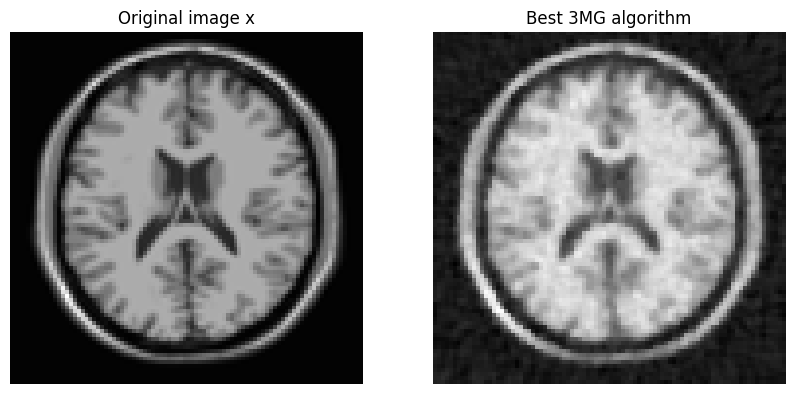

In [30]:
n_grid = 5
lambd_values = np.linspace(1.1, 1.15, n_grid)
delta_values = np.linspace(0.1, 0.12, n_grid)

best_SNR = -np.inf
best_lambd = None
best_delta = None
best_x = None

for lambd in lambd_values:
    for delta in delta_values:
        x_3MG, _, list_t = threeMG_algorithm(grad_f, x_0, lambd, delta, verbose = False)
        snr = SNR(x, x_3MG)
        print(f"SNR for lambda = {lambd}, delta = {delta}: {snr:.6f} dB, time = {list_t[-1]:.3f} seconds")
        if snr > best_SNR:
            best_SNR = snr
            best_lambd = lambd
            best_delta = delta
            best_x = x_3MG

print(f"Best SNR: {best_SNR:.6f} dB")
print(f"Best lambda: {best_lambd}")
print(f"Best delta: {best_delta}")

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].imshow(x.reshape((90, 90), order = "F"), cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Original image x')

ax[1].imshow(best_x.reshape((90, 90), order = "F"), cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('Best 3MG algorithm')

plt.show()

We usually get a SNR higher than 19.30 dB, which is higher than what was achieved with the initial values for $\lambda$ and $\delta$.